In [30]:
# ============================================================================
# 导入所有必需的库和模块
# ============================================================================

# 基础库
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# API 和模型
from ambiguity_detection_utils import AmbiguityDetector
from ollama import Client
from prompts import PSEUDOCODE_PROMPT_TEMPLATE

# 深度学习模型
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# 机器学习评估指标
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, 
    precision_recall_curve, auc,
    confusion_matrix, classification_report, 
    accuracy_score
)

print("所有库导入完成！")

所有库导入完成！


In [31]:
# ============================================================================
# 创建检测器和加载数据
# ============================================================================

# 创建语义歧义检测器
detector = AmbiguityDetector("semantic")

# 加载并准备数据
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=True)

print(f"测试数据集: {len(df_test)} 个用户故事")

Semantic歧义统计:
  有semantic歧义: 2831 (22.0%)
  无semantic歧义: 10016 (78.0%)
平衡测试集: 5662 个用户故事
  HasAmbiguity=True: 2831 (50.0%)
  HasAmbiguity=False: 2831 (50.0%)
测试数据集: 5662 个用户故事


In [32]:
df_test = df_test.sample(n=100, random_state=7)
df_test.head()

,StoryID,StoryText,HasAmbiguity
968,US-C1-1106,"As a investor, I would like to schedule appoin...",False
5183,US-C1-144,"As a account holder, I want to view account ba...",False
3065,US-C4-8139,"As a service representative, I need to handle ...",True
949,US-C4-7771,"As a network admin, I would like to pay bill t...",False
2853,US-C2-3204,"As a patient, I would like to handle patient c...",True


In [33]:
df_test.count()

StoryID         100
StoryText       100
HasAmbiguity    100
dtype: int64

In [34]:
ollama_client = Client(
    host="http://2yo6159kw603.vicp.fun/",
)

In [35]:
print("加载 CodeBERT 模型...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载 CodeBERT 模型和分词器
model_name = "microsoft/codebert-base"
code_tokenizer = AutoTokenizer.from_pretrained(model_name)
code_model = AutoModel.from_pretrained(model_name).to(device)

print(f"CodeBERT 模型已加载")
print(f"模型名称: {model_name}")
print(f"设备: {device}")

加载 CodeBERT 模型...
使用设备: cuda


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /microsoft/codebert-base/resolve/main/tokenizer_config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))"), '(Request ID: 8339d334-54f9-4309-a5da-9cf55910056d)')' thrown while requesting HEAD https://huggingface.co/microsoft/codebert-base/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/resolve-cache/models/microsoft/codebert-base/3b0952feddeffad0063f274080e3c23d75e7eb39/tokenizer_config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))"), '(Request ID: 62377803-b644-413b-9ab8-fb2f4fba4955)')' thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/microsoft/codebert-base/3b0952fedde

CodeBERT 模型已加载
模型名称: microsoft/codebert-base
设备: cuda


In [36]:
# 定义代码embedding函数
def get_code_embedding(code_text, tokenizer, model, device):
    """
    获取代码文本的embedding向量（使用CodeBERT）
    
    使用 CodeBERT 的 [CLS] token 表示作为整个代码段的语义表示
    
    参数:
        code_text: 代码文本
        tokenizer: AutoTokenizer 分词器
        model: AutoModel CodeBERT 模型
        device: 计算设备 (cuda/cpu)
    
    返回:
        embedding: 代码embedding向量 (768,)，已转换为 numpy 数组
    """
    # 对输入进行分词并转换为 token IDs
    tokens = tokenizer(
        code_text,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    
    # 获取模型输出
    with torch.no_grad():
        outputs = model(**tokens)
        # outputs[0] 是最后一层的所有 token 的表示，shape: (batch_size, seq_len, hidden_size)
        # 我们取 [CLS] token 的表示（第一个 token）作为整个代码段的表示
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
    
    # 转换为 numpy 数组并返回
    return cls_embedding.cpu().numpy().squeeze()  # 返回 (768,)

print("get_code_embedding 函数已定义")

get_code_embedding 函数已定义


In [37]:
# 定义计算伪代码相似度分数的函数
def calculate_pseudocode_similarity_score(pseudocodes, tokenizer, model, device):
    """
    计算伪代码批次的相似度分数
    
    使用 CodeBERT 获取代码语义表示，根据论文方法计算歧义分数：
    g(P_i^(q)) = ∑_{(p_ij, p_ij') ∈ P_i^(q) × P_i^(q)} (1 - sim(p_ij, p_ij'))
    
    其中 sim 是基于 CodeBERT 语义表示的余弦相似度，范围 [0, 1]
    
    参数:
        pseudocodes: 伪代码列表
        tokenizer: AutoTokenizer 分词器
        model: AutoModel CodeBERT 模型
        device: 计算设备 (cuda/cpu)
    
    返回:
        score: 伪代码歧义分数（高分表示高歧义）
        similarity_matrix: 相似度矩阵 (n, n)，值在 [0, 1] 范围内
    """
    n = len(pseudocodes)
    
    if n < 2:
        return 0.0, np.array([[1.0]])
    
    # 1. 为所有伪代码获取 CodeBERT embedding
    embeddings = []
    for pseudocode in pseudocodes:
        try:
            embedding = get_code_embedding(pseudocode, tokenizer, model, device)
            embeddings.append(embedding)
        except Exception as e:
            print(f"获取 embedding 失败: {str(e)}")
            # 如果失败，返回零向量
            embeddings.append(np.zeros(768))
    
    embeddings = np.array(embeddings)  # shape: (n, 768)
    
    # 2. 规范化 embedding 向量
    embeddings_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
    
    # 3. 计算所有伪代码对的余弦相似度矩阵
    # 余弦相似度 = dot(u, v) / (||u|| * ||v||)
    # 由于我们已经规范化，直接做矩阵乘法
    similarity_matrix = np.dot(embeddings_norm, embeddings_norm.T)  # shape: (n, n)
    
    # 确保相似度在 [0, 1] 范围内（由于浮点误差可能略超）
    similarity_matrix = np.clip(similarity_matrix, 0.0, 1.0)
    
    # 4. 计算歧义分数：所有非对角线元素的（1 - 相似度）之和
    score = 0.0
    for i in range(n):
        for j in range(n):
            if i != j:
                dissimilarity = 1.0 - similarity_matrix[i][j]
                score += dissimilarity
    
    return score, similarity_matrix

print("calculate_pseudocode_similarity_score 函数已定义")

calculate_pseudocode_similarity_score 函数已定义


In [38]:
prompt_template = PSEUDOCODE_PROMPT_TEMPLATE

# 定义清理伪代码的函数
def clean_pseudocode(pseudocode_text):
    """
    清理伪代码中的 markdown code block 标记
    
    移除开头的 ```pseudocode、``` 或 ```\n
    移除结尾的 ```
    
    参数:
        pseudocode_text: 原始伪代码文本
    
    返回:
        cleaned_text: 清理后的伪代码文本
    """
    text = pseudocode_text.strip()
    
    # 移除开头的 markdown 标记
    if text.startswith('```pseudocode'):
        text = text[len('```pseudocode'):].lstrip('\n')
    elif text.startswith('```'):
        text = text[3:].lstrip('\n')
    
    # 移除结尾的 ``` 标记
    if text.endswith('```'):
        text = text[:-3].rstrip()
    
    return text.strip()

print("clean_pseudocode 函数已定义")

clean_pseudocode 函数已定义


In [39]:
# 14. 生成伪代码 - 为每个需求生成10份伪代码
# 使用前面的df_test数据（前10个故事）
pseudocode_results = []

print("开始生成伪代码...\n")

for no, (index, row) in enumerate(df_test.iterrows()):
    story_id = row['StoryID']
    story_text = row['StoryText']
    pseudocodes = []
    
    print(f"Processed story {no + 1}/{len(df_test)}: {row['StoryID']}")
    
    # 为该故事生成10份伪代码
    for attempt in range(10):
        # 使用导入的模板，通过 format() 替换 {REQUIREMENT} 占位符
        formatted_prompt = PSEUDOCODE_PROMPT_TEMPLATE.format(REQUIREMENT=story_text)
        
        try:
            response = ollama_client.chat(model='gpt-oss:20b', messages=[
                {
                    'role': 'user',
                    'content': formatted_prompt,
                },
            ])
            pseudocode = response.message.content
            # 清理伪代码中的 markdown 标记
            pseudocode = clean_pseudocode(pseudocode)
            pseudocodes.append(pseudocode)
            print(f"  生成伪代码 {attempt + 1}/10")
        except Exception as e:
            print(f"  生成伪代码 {attempt + 1}/10 失败: {str(e)}")
            pseudocodes.append(f"Error: {str(e)}")
    
    # 计算该故事的伪代码相似度分数
    if all(not pc.startswith("Error") for pc in pseudocodes):
        try:
            score, similarity_matrix = calculate_pseudocode_similarity_score(
                pseudocodes,
                code_tokenizer,
                code_model,
                device
            )
            pseudocode_ambiguity_level = 'High' if score > 5 else ('Medium' if score > 2 else 'Low')
        except Exception as e:
            print(f"  计算相似度分数失败: {str(e)}")
            score = 0.0
            similarity_matrix = np.array([[1.0]])
            pseudocode_ambiguity_level = 'Error'
    else:
        score = 0.0
        similarity_matrix = np.array([[1.0]])
        pseudocode_ambiguity_level = 'Error'
    
    pseudocode_results.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'HasAmbiguity': row['HasAmbiguity'],
        'NumPseudocodes': len(pseudocodes),
        'PseudocodeScore': score,
        'PseudocodeAmbiguityLevel': pseudocode_ambiguity_level,
        'Pseudocodes': pseudocodes
    })
    
    print(f"  相似度分数: {score:.4f}, 歧义级别: {pseudocode_ambiguity_level}\n")

print(f"完成生成 {len(pseudocode_results)} 个故事的伪代码")

开始生成伪代码...

Processed story 1/100: US-C1-1106
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.5203, 歧义级别: Low

Processed story 2/100: US-C1-144
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.4992, 歧义级别: Low

Processed story 3/100: US-C4-8139
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.6404, 歧义级别: Low

Processed story 4/100: US-C4-7771
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.4962, 歧义级别: Low

Processed story 5/100: US-C2-3204
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.5250, 歧义级别: Low

Processed story 6/100: U

In [40]:
pseudocode_results[0]["Pseudocodes"]

['# Data structures ----------------------------------------------------\nclass Investor:\n    id\n    name\n    email\n    # list of appointments the investor has scheduled\n    appointments : List<Appointment>\n\nclass Appointment:\n    id\n    investor_id\n    date_time        # datetime of the appointment\n    duration_minutes\n    location         # e.g., "Zoom" or "Office"\n    purpose          # brief description\n    detailed_specifications   # text or structured data\n    comprehensive_requirements # text or structured data\n    status           # "Scheduled", "Confirmed", "Cancelled", "Completed"\n\n# Global repositories (in-memory for simplicity) --------------------\nINVESTORS : Map<Investor.id, Investor>\nAPPOINTMENTS : Map<Appointment.id, Appointment>\n\n# Utility functions --------------------------------------------------\nfunction generate_id() -> string\n    # returns a unique identifier (e.g., UUID)\n\nfunction current_datetime() -> DateTime\n    # returns the curren

In [41]:
# 创建DataFrame用于分析
scores_df = pd.DataFrame(pseudocode_results)
print(f"\n完成处理 {len(pseudocode_results)} 个用户故事")
print("\n澄清分数统计:")
print(scores_df[['NumPseudocodes', 'PseudocodeScore', 'PseudocodeAmbiguityLevel']].describe())


完成处理 100 个用户故事

澄清分数统计:
       NumPseudocodes  PseudocodeScore
count           100.0       100.000000
mean             10.0         0.502742
std               0.0         0.105952
min              10.0         0.246430
25%              10.0         0.436076
50%              10.0         0.502719
75%              10.0         0.555849
max              10.0         1.003433


In [42]:
scores_df.head()

,StoryID,StoryText,HasAmbiguity,NumPseudocodes,PseudocodeScore,PseudocodeAmbiguityLevel,Pseudocodes
0,US-C1-1106,"As a investor, I would like to schedule appoin...",False,10,0.520324,Low,[# Data structures ---------------------------...
1,US-C1-144,"As a account holder, I want to view account ba...",False,10,0.499158,Low,[// Data structures\nDEFINE STRUCT User\n i...
2,US-C4-8139,"As a service representative, I need to handle ...",True,10,0.640409,Low,[# Data structures\nclass Customer:\n id\n ...
3,US-C4-7771,"As a network admin, I would like to pay bill t...",False,10,0.496217,Low,[# Data structures ---------------------------...
4,US-C2-3204,"As a patient, I would like to handle patient c...",True,10,0.525032,Low,[// DATA STRUCTURES\nPatient {\n id\n na...


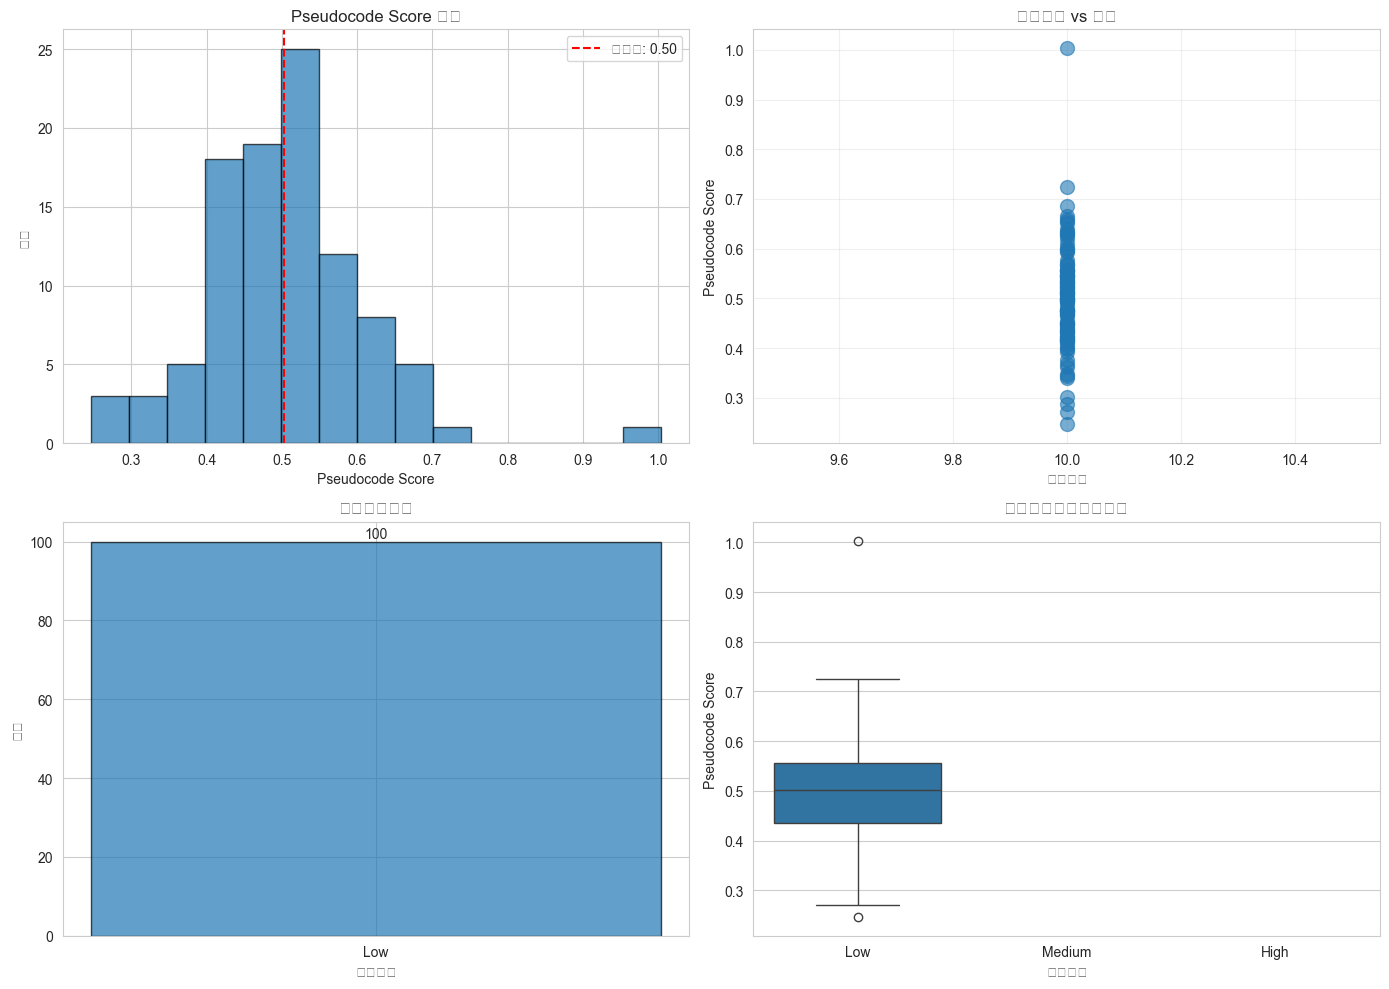

分析结果已保存到 clarification_score_analysis.png


In [43]:
# 6. 可视化分析结果
# 设置图表风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Pseudocode Score 分布直方图
axes[0, 0].hist(scores_df['PseudocodeScore'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Pseudocode Score')
axes[0, 0].set_ylabel('频率')
axes[0, 0].set_title('Pseudocode Score 分布')
axes[0, 0].axvline(scores_df['PseudocodeScore'].mean(), color='red', linestyle='--', label=f'平均值: {scores_df["PseudocodeScore"].mean():.2f}')
axes[0, 0].legend()

# 2. 澄清数量 vs 分数散点图
axes[0, 1].scatter(scores_df['NumPseudocodes'], scores_df['PseudocodeScore'], alpha=0.6, s=100)
axes[0, 1].set_xlabel('澄清数量')
axes[0, 1].set_ylabel('Pseudocode Score')
axes[0, 1].set_title('澄清数量 vs 分数')
axes[0, 1].grid(True, alpha=0.3)

# 3. 歧义级别分布
ambiguity_counts = scores_df['PseudocodeAmbiguityLevel'].value_counts()
axes[1, 0].bar(ambiguity_counts.index, ambiguity_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('歧义级别')
axes[1, 0].set_ylabel('数量')
axes[1, 0].set_title('歧义级别分布')
for i, v in enumerate(ambiguity_counts.values):
    axes[1, 0].text(i, v + 0.1, str(v), ha='center', va='bottom')

# 4. 评分箱线图（按歧义级别）
order = ['Low', 'Medium', 'High']
scores_df_sorted = scores_df.copy()
scores_df_sorted['PseudocodeAmbiguityLevel'] = pd.Categorical(scores_df_sorted['PseudocodeAmbiguityLevel'], categories=order, ordered=True)
sns.boxplot(data=scores_df_sorted, x='PseudocodeAmbiguityLevel', y='PseudocodeScore', ax=axes[1, 1])
axes[1, 1].set_xlabel('歧义级别')
axes[1, 1].set_ylabel('Pseudocode Score')
axes[1, 1].set_title('各歧义级别的分数分布')

plt.tight_layout()
plt.savefig('clarification_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("分析结果已保存到 clarification_score_analysis.png")

In [44]:
# 8. 计算 AUROC 和 F1 分数用于评估歧义检测性能
# 合并 df_test 的真实标签和 scores_df 的预测分数
# 创建一个映射字典，将 StoryID 与 HasAmbiguity 对应
true_labels_dict = dict(zip(df_test['StoryID'], df_test['HasAmbiguity']))

# 为 scores_df 添加真实标签
scores_df['TrueLabel'] = scores_df['StoryID'].map(true_labels_dict)

# 移除没有真实标签的行
scores_df_with_labels = scores_df.dropna(subset=['TrueLabel'])

print(f"用于评估的样本数: {len(scores_df_with_labels)}")
print(f"真实标签分布:")
print(scores_df_with_labels['TrueLabel'].value_counts())
print()

# 准备数据
y_true = scores_df_with_labels['TrueLabel'].astype(int).values
y_scores = scores_df_with_labels['PseudocodeScore'].values

# 1. 计算 AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"消歧方法 - AUROC: {auroc:.4f}")

# 获取ROC曲线的FPR和TPR
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# 2. 寻找最优的阈值（使用约登指数）
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"最优阈值（基于约登指数）: {optimal_threshold:.4f}")

# 3. 使用最优阈值进行二分类
y_pred = (y_scores >= optimal_threshold).astype(int)

# 4. 计算 F1 分数
f1 = f1_score(y_true, y_pred)
print(f"消歧方法 - F1 Score: {f1:.4f}")

# 5. 计算其他评估指标（用于可视化和后续分析，但不在主要输出中突出）
accuracy = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 6. Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

print("\n" + "="*50)
print(f"\n总结:")
print(f"  AUROC: {auroc:.4f}")
print(f"  F1 Score: {f1:.4f}\n")
print("="*50)

用于评估的样本数: 100
真实标签分布:
TrueLabel
False    51
True     49
Name: count, dtype: int64

消歧方法 - AUROC: 0.6663
最优阈值（基于约登指数）: 0.5475
消歧方法 - F1 Score: 0.5455


总结:
  AUROC: 0.6663
  F1 Score: 0.5455



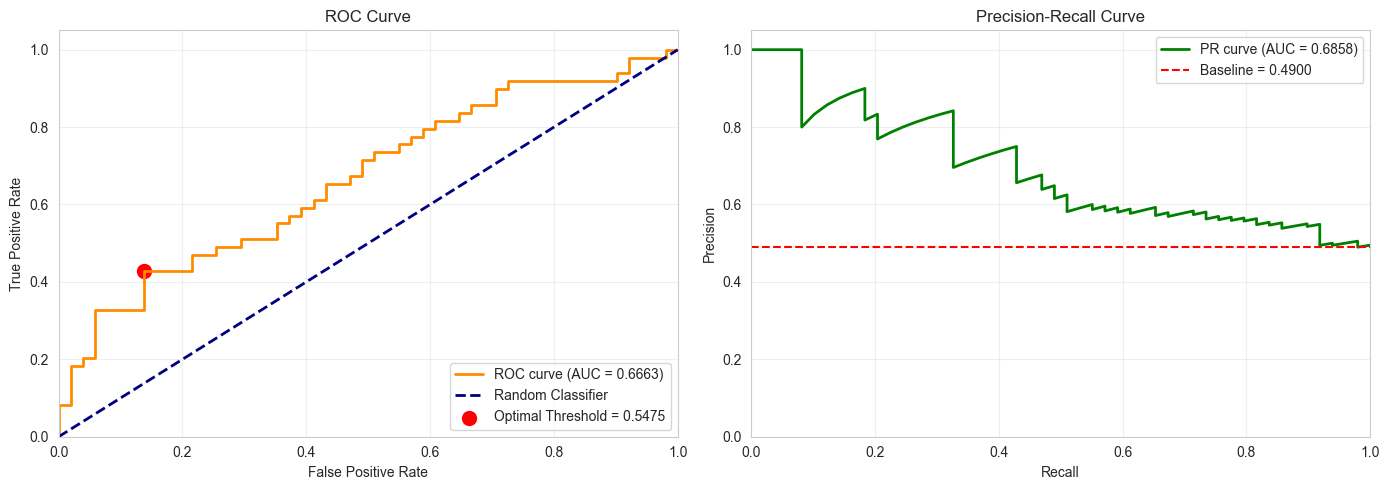

评估曲线已保存到 ambiguity_detection_evaluation.png

PR-AUC (Precision-Recall AUC): 0.6858


In [45]:
# 9. 可视化 ROC 曲线和 Precision-Recall 曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC 曲线
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auroc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
                label=f'Optimal Threshold = {optimal_threshold:.4f}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=np.sum(y_true) / len(y_true), color='red', linestyle='--', 
                label=f'Baseline = {np.sum(y_true) / len(y_true):.4f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ambiguity_detection_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("评估曲线已保存到 ambiguity_detection_evaluation.png")
print(f"\nPR-AUC (Precision-Recall AUC): {pr_auc:.4f}")

In [46]:
scores_df.sort_values(by='PseudocodeScore', ascending=False, inplace=True)

In [47]:
scores_df.loc[scores_df['StoryID'] == 'US-C5-9552'].head()
# 打印第一行的 Pseudocodes 值
print(scores_df.loc[0, 'Pseudocodes'][0])

# Data structures ----------------------------------------------------
class Investor:
    id
    name
    email
    # list of appointments the investor has scheduled
    appointments : List<Appointment>

class Appointment:
    id
    investor_id
    date_time        # datetime of the appointment
    duration_minutes
    location         # e.g., "Zoom" or "Office"
    purpose          # brief description
    detailed_specifications   # text or structured data
    comprehensive_requirements # text or structured data
    status           # "Scheduled", "Confirmed", "Cancelled", "Completed"

# Global repositories (in-memory for simplicity) --------------------
INVESTORS : Map<Investor.id, Investor>
APPOINTMENTS : Map<Appointment.id, Appointment>

# Utility functions --------------------------------------------------
function generate_id() -> string
    # returns a unique identifier (e.g., UUID)

function current_datetime() -> DateTime
    # returns the current system datetime

function va

In [48]:
scores_df.head()

,StoryID,StoryText,HasAmbiguity,NumPseudocodes,PseudocodeScore,PseudocodeAmbiguityLevel,Pseudocodes,TrueLabel
94,US-C6-11188,"As a nurse, I want to process medical informat...",True,10,1.003433,Low,[/* ---------- Data Structures ---------- */\n...,True
72,US-C6-11214,"As a nurse, I want to process medical informat...",True,10,0.724439,Low,[// Core data structures\nPatient {\n id\n ...,True
60,US-C2-4046,"As a medical staff, I want to process medical ...",True,10,0.686240,Low,[// Data structures\nRecord PatientRecord {\n ...,True
34,US-C2-2347,"As a healthcare provider, I need to manage hea...",True,10,0.666478,Low,[/********************************************...,True
93,US-C2-3114,"As a patient, I would like to update patient i...",False,10,0.660597,Low,[// Data structures --------------------------...,False


In [49]:
scores_df.tail()

,StoryID,StoryText,HasAmbiguity,NumPseudocodes,PseudocodeScore,PseudocodeAmbiguityLevel,Pseudocodes,TrueLabel
76,US-C1-463,"As a bank customer, I need to schedule appoint...",False,10,0.339673,Low,[# -------------------------------------------...,False
54,US-C3-6932,"As a customer, I would like to add to cart to ...",False,10,0.301904,Low,[# Data structures\nclass Product:\n id ...,False
23,US-C7-11507,"As a customer, I need to add to cart so that I...",False,10,0.288420,Low,[// ------------------------------------------...,False
46,US-C3-6099,"As a store owner, I would like to manage produ...",True,10,0.270864,Low,[# Data Structures\nclass Product:\n id ...,True
48,US-C7-11669,"As a vendor, I would like to leave review to c...",False,10,0.246430,Low,[// Data structures\nPurchase:\n id\n ve...,False
